In [1]:
import numpy as np
import cfml.misc
import cfml.transform
import cfml.bayes

In [2]:
data_provider = cfml.misc.Lab4DataProvider(r"C:\Programing\sem6\ml\lab4\data").load()

In [3]:
def message_transform(msg: cfml.misc.Message, *transformers):
    obj = msg.subject + msg.content
    for transformer in transformers:
        obj = transformer(obj)
    return (obj, msg.label)

In [4]:
folds_by_n = dict()
transformers_by_n = dict()
for n in range(1, 4):
    hashable_to_int = cfml.bayes.HashableToIntTransformer()
    transformers_by_n[n] = (cfml.transform.NGramsTransformer(n), lambda x: list(map(hashable_to_int, x)))
    folds_by_n[n] = data_provider.apply_transformer(lambda msg: message_transform(msg, *transformers_by_n[n]))

In [5]:
def accuracy(nn, _np, pn, pp):
    # print(nn, _np, pn, pp)
    return (nn + pp) / (nn + _np + pn + pp)

In [6]:
ln_alpha_bounds = (-20, 0)

def count_accuracy(ln_alpha, folds, classifiers):
    nn, _np, pn, pp = 0, 0, 0, 0
    for i, classifier in enumerate(classifiers):
        classifier.alpha = np.exp(ln_alpha)
        for msg in folds[i]:
            y_pred = classifier(msg[0], hard=True)
            y_real = msg[1]   
            if y_pred == 0.0:
                if y_real == 0.0:
                    nn += 1
                else:
                    pn += 1
            else:
                if y_real == 0.0:
                    _np += 1
                else:
                    pp += 1
    return accuracy(nn, _np, pn, pp)

def accuracy_target(trial, folds, classifiers):
    ln_alpha = trial.suggest_float("ln_alpha", *ln_alpha_bounds)
    return count_accuracy(ln_alpha, folds, classifiers)
   

In [7]:
classifiers_by_n = dict()

for n in range(1, 4):
    classifiers_by_n[n] = []
    for i in range(len(folds_by_n[n])):
        train = []
        for j in range(len(folds_by_n[n])):
            if i != j:
                train += folds_by_n[n][j]
        
        X_train, Y_train = [], []
        for msg in train:
            X_train.append(msg[0])
            Y_train.append(msg[1])
            
        model = cfml.bayes.NaiveBayesClassifier(X_train, Y_train)
        model.lambdas = (1.0, 1.0)
        classifiers_by_n[n].append(model)

In [8]:
import optuna

def best_study(n, trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: accuracy_target(trial, folds_by_n[n], classifiers_by_n[n]), n_trials=trials)
    return study

def bruteforce(n):
    pass

In [9]:
studies = [best_study(i) for i in range(1, 4)]

[I 2022-05-25 01:55:26,438] A new study created in memory with name: no-name-5b5c494f-9fe7-454d-b3d7-46fc5d323f0e
[I 2022-05-25 01:55:30,843] Trial 0 finished with value: 0.9577981651376147 and parameters: {'ln_alpha': -5.332511733693622}. Best is trial 0 with value: 0.9577981651376147.
[I 2022-05-25 01:55:35,119] Trial 1 finished with value: 0.9669724770642202 and parameters: {'ln_alpha': -9.135754549244666}. Best is trial 1 with value: 0.9669724770642202.
[I 2022-05-25 01:55:39,573] Trial 2 finished with value: 0.9669724770642202 and parameters: {'ln_alpha': -9.609040890462083}. Best is trial 1 with value: 0.9669724770642202.
[I 2022-05-25 01:55:43,876] Trial 3 finished with value: 0.9678899082568807 and parameters: {'ln_alpha': -11.60514383039086}. Best is trial 3 with value: 0.9678899082568807.
[I 2022-05-25 01:55:48,268] Trial 4 finished with value: 0.9715596330275229 and parameters: {'ln_alpha': -15.987809547997385}. Best is trial 4 with value: 0.9715596330275229.
[I 2022-05-25 0

In [10]:
best_value = 0.0
best_alpha, best_n = None, None

for n, study in enumerate(studies):
    print("best accuracy for n =", n + 1, "is", study.best_value, "with params" + str(study.best_params))
    if best_value < study.best_value:
        best_value = study.best_value
        best_n = n + 1
        best_alpha = np.exp(study.best_params["ln_alpha"])

print("overall best accuracy", best_value, "for alpha", best_alpha, "n", best_n)

best accuracy for n = 1 is 0.9715596330275229 with params{'ln_alpha': -15.987809547997385}
best accuracy for n = 2 is 0.9779816513761468 with params{'ln_alpha': -19.89916002555471}
best accuracy for n = 3 is 0.9642201834862385 with params{'ln_alpha': -19.999755667146516}
overall best accuracy 0.9779816513761468 for alpha 2.2798412455370267e-09 n 2


In [11]:
def count_accuracy_1(test_fold, classifier):
    nn, _np, pn, pp = 0, 0, 0, 0
    for msg in test_fold:
        y_pred = classifier(msg[0], hard=True)
        # print(classifier(msg[0], hard=False))
        y_real = msg[1]
        # print("ca:", y_pred, y_real)
        if y_pred == 0.0:
            if y_real == 0.0:
                nn += 1
            else:
                pn += 1
        else:
            if y_real == 0.0:
                _np += 1
            else:
                pp += 1
    return accuracy(nn, _np, pn, pp)

In [12]:
best_classifier = classifiers_by_n[best_n][6]
folds = folds_by_n[best_n]
test_fold = folds_by_n[best_n][6]
best_classifier.lambdas = (1.0, 1.0)
best_classifier.alpha = best_alpha

In [13]:
count_accuracy_1(test_fold, best_classifier)

0.963302752293578

In [14]:
from collections import namedtuple
import matplotlib.pyplot as plt

IndexProbLabel = namedtuple("IndexProbLabel", ("index", "prob", "y_real"))

def roc_auc(classifier, test_fold):
    objs = []
    cnt_spam, cnt_legit = 0, 0
    for i, msg in enumerate(test_fold):
        y_spam_prob = classifier(msg[0])[1]
        objs.append(IndexProbLabel(i, y_spam_prob, msg[1]))
        if msg[1] == 1.0:
            cnt_spam += 1
        else:
            cnt_legit += 1
    # print(cnt_spam, cnt_legit)
    objs.sort(key=lambda x: x.prob)
    
    step_x = 1.0 / cnt_spam
    step_y = 1.0 / cnt_legit
    xs = []
    ys = []
    x, y = 0, 0
    
    auc = 0.0
    
    def up():
        nonlocal x
        nonlocal y
        xs.append(x)
        ys.append(y)
        y += step_y
    
    def right():
        nonlocal x
        nonlocal y
        nonlocal auc
        xs.append(x)
        ys.append(y)
        x += step_x
        auc += step_x * ys[-1]

    for obj in objs:
        if obj.y_real == 1.0:
            right()
        else:
            up()
    
    plt.plot(xs, ys)
    plt.show()
    
    return auc

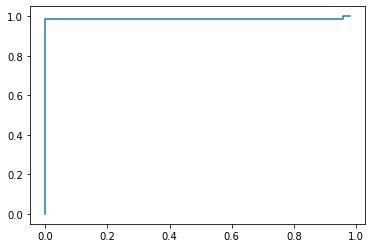

0.9842896174863387

In [15]:
roc_auc(best_classifier, test_fold)

In [16]:
def count_fp(folds, classifier):
    fp = 0
    for i in range(len(folds)):
        for msg in folds[i]:
            y_pred = classifier(msg[0], hard=True)
            y_real = msg[1]
            if y_pred == 1.0 and y_real == 0.0:
                fp += 1
    return fp


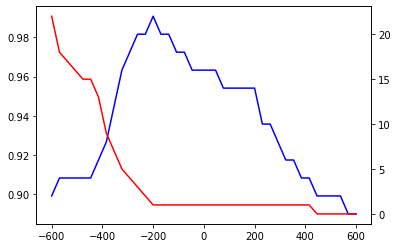

In [17]:
ln_lambda_legits = np.linspace(-600, 600, num=40)
accuracies = []
false_positives = []

for ln_lambda_legit in ln_lambda_legits:
    best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
    accuracies.append(count_accuracy_1(test_fold, best_classifier))
    # false_positives.append(count_fp((test_fold, ), best_classifier))
    false_positives.append(count_fp(folds, best_classifier))

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(ln_lambda_legits, accuracies, color='blue')
ax_right.plot(ln_lambda_legits, false_positives, color='red')
    
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


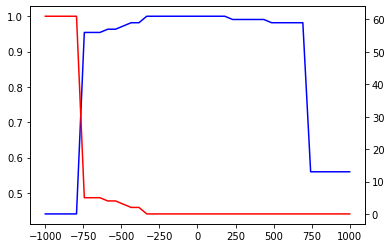

 10%|█         | 1/10 [00:27<04:04, 27.20s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


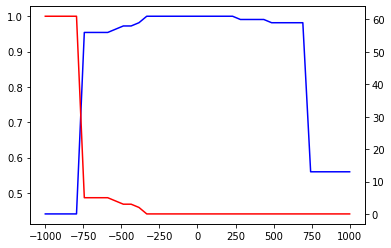

 20%|██        | 2/10 [00:54<03:36, 27.09s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


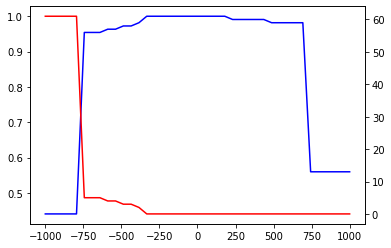

 30%|███       | 3/10 [01:21<03:11, 27.35s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


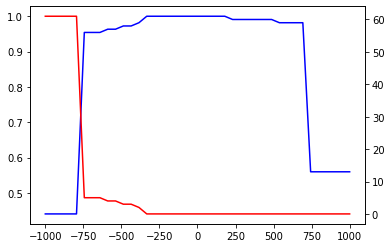

 40%|████      | 4/10 [01:49<02:43, 27.29s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


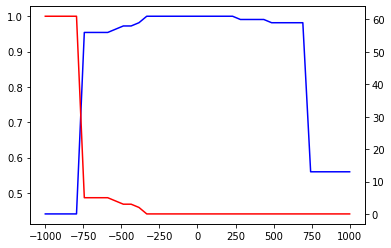

 50%|█████     | 5/10 [02:16<02:16, 27.26s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


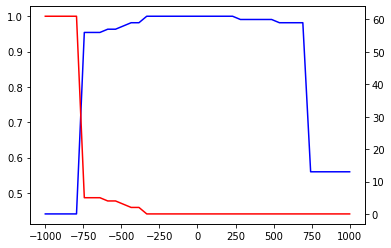

 60%|██████    | 6/10 [02:44<01:49, 27.46s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


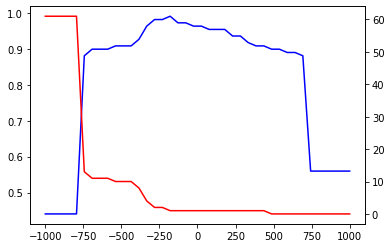

 70%|███████   | 7/10 [03:05<01:16, 25.35s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


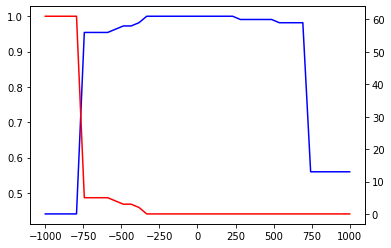

 80%|████████  | 8/10 [03:32<00:51, 25.89s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


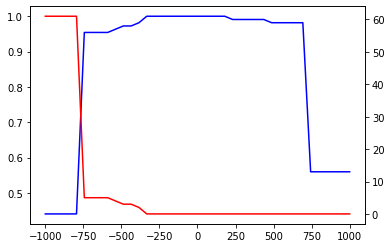

 90%|█████████ | 9/10 [04:00<00:26, 26.51s/it]C:\Programing\sem6\ml\lab4\cfml\bayes.py:52: RuntimeWarning: divide by zero encountered in log
  self._log_lambda_apriori_p = np.log(self.lambdas) + np.log(self._log_lambda_apriori_p)
C:\Users\geranazavr555\AppData\Local\Temp\ipykernel_928\520834780.py:11: RuntimeWarning: overflow encountered in exp
  best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
C:\Programing\sem6\ml\lab4\cfml\bayes.py:99: RuntimeWarning: invalid value encountered in subtract
  result = np.exp(result - np.max(result))


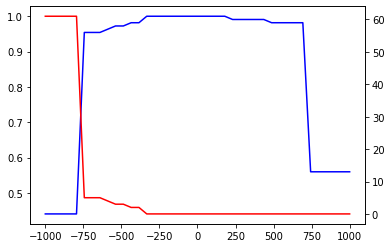

100%|██████████| 10/10 [04:27<00:00, 26.78s/it]


In [18]:
from tqdm import tqdm

for i in tqdm(range(len(folds))):
    ln_lambda_legits = np.linspace(-1000, 1000, num=40)
    accuracies = []
    false_positives = []
    
    best_classifier = classifiers_by_n[2][i]
    
    for ln_lambda_legit in ln_lambda_legits:
        best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
        accuracies.append(count_accuracy_1(test_fold, best_classifier))
        false_positives.append(count_fp((test_fold, ), best_classifier))

    fig, ax_left = plt.subplots()
    ax_right = ax_left.twinx()

    ax_left.plot(ln_lambda_legits, accuracies, color='blue')
    ax_right.plot(ln_lambda_legits, false_positives, color='red')

    plt.show()

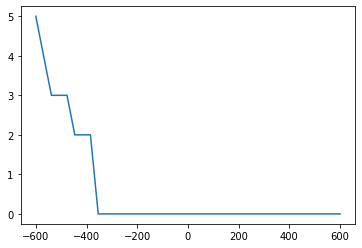

In [19]:
false_positives = []
accuracies = []
ln_lambda_legits = np.linspace(-600, 600, num=40)
for ln_lambda_legit in ln_lambda_legits:
    best_classifier.lambdas = (np.exp(ln_lambda_legit), 1.0)
    accuracies.append(count_fp((test_fold, ), best_classifier))

plt.plot(ln_lambda_legits, accuracies)
plt.show()